In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_path = "/content/drive/MyDrive/image_tensors.zip"
extract_path = "data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
zip_path = "/content/drive/MyDrive/resnet50_artist_classification.keras.zip"
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import torch
from torch.utils.data import Dataset


class PTImageFlatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for fname in os.listdir(root_dir):
            if fname.endswith(".pt"):
                path = os.path.join(root_dir, fname)
                data = torch.load(path)
                label_str = data['label']
                self.samples.append((path, label_str))

        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set([s[1] for s in self.samples])))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label_str = self.samples[idx]
        data = torch.load(path)
        tensor = data['tensor']  # shape: [3, 224, 224]
        label = self.label_to_idx[label_str]

        if self.transform:
            tensor = self.transform(tensor)

        return tensor.float(), label



In [ ]:
from torchvision import transforms
import os
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = PTImageFlatDataset('/content/data/image_tensors', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



In [ ]:
for images, labels in dataloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break



Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.8MB/s]


[Epoch 1/20] Train Loss: 2.7766 | Test Loss: 2.3574 | Train Acc: 0.3418 | Test Acc: 0.4375
[Epoch 2/20] Train Loss: 1.3980 | Test Loss: 1.8085 | Train Acc: 0.8544 | Test Acc: 0.5625
[Epoch 3/20] Train Loss: 0.7007 | Test Loss: 1.4225 | Train Acc: 0.9367 | Test Acc: 0.6375
[Epoch 4/20] Train Loss: 0.2959 | Test Loss: 1.2257 | Train Acc: 0.9778 | Test Acc: 0.7000
[Epoch 5/20] Train Loss: 0.1159 | Test Loss: 1.1533 | Train Acc: 0.9968 | Test Acc: 0.7125
[Epoch 6/20] Train Loss: 0.0600 | Test Loss: 1.1665 | Train Acc: 1.0000 | Test Acc: 0.6750
[Epoch 7/20] Train Loss: 0.0345 | Test Loss: 1.1387 | Train Acc: 1.0000 | Test Acc: 0.7000
[Epoch 8/20] Train Loss: 0.0258 | Test Loss: 1.1380 | Train Acc: 1.0000 | Test Acc: 0.7125
[Epoch 9/20] Train Loss: 0.0258 | Test Loss: 1.1274 | Train Acc: 1.0000 | Test Acc: 0.7125
[Epoch 10/20] Train Loss: 0.0234 | Test Loss: 1.1184 | Train Acc: 1.0000 | Test Acc: 0.7125
[Epoch 11/20] Train Loss: 0.0137 | Test Loss: 1.0976 | Train Acc: 1.0000 | Test Acc: 0.71

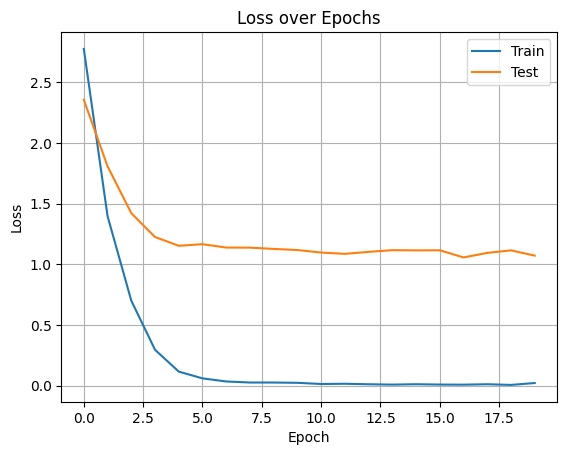

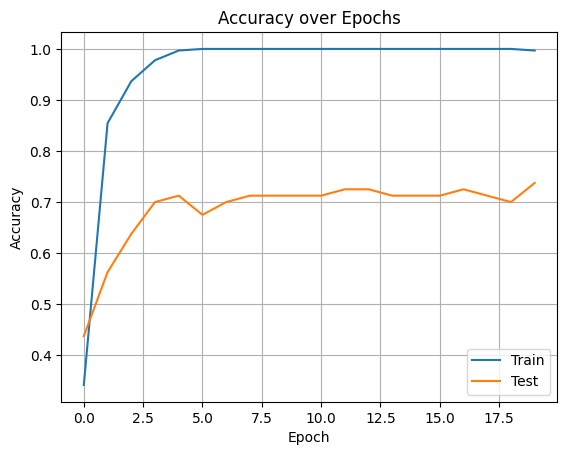

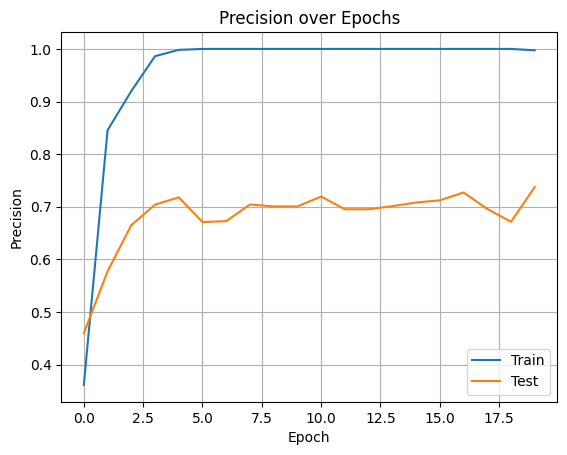

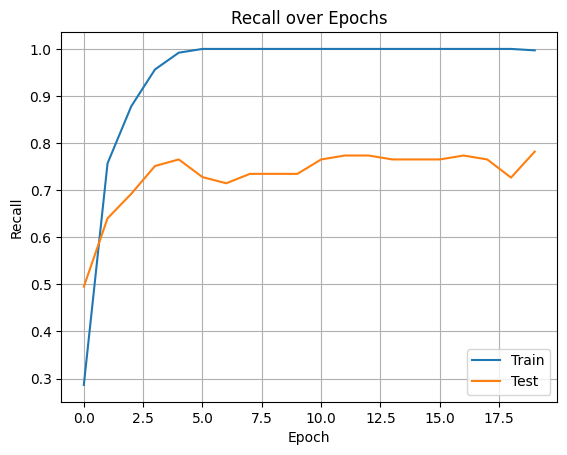

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np



# Train / Test split (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(dataset.label_to_idx))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 存储每一轮的指标
history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
    'train_prec': [],
    'test_prec': [],
    'train_rec': [],
    'test_rec': []
}

# 训练
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    y_true_train = []
    y_pred_train = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())

    # Eval
    model.eval()
    test_losses = []
    y_true_test = []
    y_pred_test = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    # Metrics
    history['train_loss'].append(np.mean(train_losses))
    history['test_loss'].append(np.mean(test_losses))

    for name, true, pred in [
        ('train', y_true_train, y_pred_train),
        ('test', y_true_test, y_pred_test)
    ]:
        acc = accuracy_score(true, pred)
        prec = precision_score(true, pred, average='macro', zero_division=0)
        rec = recall_score(true, pred, average='macro', zero_division=0)
        history[f'{name}_acc'].append(acc)
        history[f'{name}_prec'].append(prec)
        history[f'{name}_rec'].append(rec)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {history['train_loss'][-1]:.4f} | "
          f"Test Loss: {history['test_loss'][-1]:.4f} | "
          f"Train Acc: {history['train_acc'][-1]:.4f} | "
          f"Test Acc: {history['test_acc'][-1]:.4f}")

# 绘图函数
def plot_metric(metric_name, ylabel):
    plt.figure()
    plt.plot(history[f'train_{metric_name}'], label='Train')
    plt.plot(history[f'test_{metric_name}'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# 可视化所有指标
plot_metric('loss', 'Loss')
plot_metric('acc', 'Accuracy')
plot_metric('prec', 'Precision')
plot_metric('rec', 'Recall')


In [ ]:
import tensorflow as tf

# 加载模型
old_model = tf.keras.models.load_model("/content/data/resnet50_artist_classification.keras")
_ = old_model(tf.keras.Input(shape=(224, 224, 3), name="temp_input"))

# 正确取层 (明确使用名字，避免层索引混乱)
resnet50_layer = old_model.get_layer("resnet50")
global_avg_pool = old_model.get_layer("global_average_pooling2d")

# 新模型定义
new_input = tf.keras.Input(shape=(224, 224, 3), name="new_input_layer")
x = resnet50_layer(new_input)
x = global_avg_pool(x)
new_output = tf.keras.layers.Dense(25, activation='softmax', name="new_logits")(x)

model = tf.keras.Model(inputs=new_input, outputs=new_output)

# 编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ new_input_layer (InputLayer)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_logits (Dense)              │ (None, 25)             │        51,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,638,937 (90.18 MB)

 Trainable params: 51,225 (200.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
print(model.input.shape)
print(model.output.shape)

(None, 224, 224, 3)
(None, 25)


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the learning rate scheduler as a function
def scheduler(epoch, lr):
    if epoch < 5: return 0.01
    elif epoch < 10: return 0.001
    elif epoch < 15: return 0.0001
    else: return 0.00001

# Create the optimizer with an initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Create the learning rate scheduler callback to use during training
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# History dictionary
history = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_rec': [], 'test_rec': []
}

num_epochs = 20

for epoch in range(num_epochs):

    current_lr = scheduler(epoch, 0)
    optimizer.learning_rate = current_lr
    print("current Learning Rate",current_lr)
    train_losses, y_true_train, y_pred_train = [], [], []

    # Training loop
    for images, labels in train_loader:
        images = tf.transpose(images, [0, 2, 3, 1])  # [B, H, W, C]
        labels = tf.cast(labels, tf.int32)

        with tf.GradientTape() as tape:
            logits = model(images, training=True)
            loss = loss_fn(labels, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_losses.append(loss.numpy())
        y_true_train.extend(labels.numpy())
        y_pred_train.extend(tf.argmax(logits, axis=1).numpy())

    # Evaluation loop
    test_losses, y_true_test, y_pred_test = [], [], []

    for images, labels in test_loader:
        images = tf.transpose(images, [0, 2, 3, 1])
        labels = tf.cast(labels, tf.int32)

        logits = model(images, training=False)
        loss = loss_fn(labels, logits)
        test_losses.append(loss.numpy())

        y_true_test.extend(labels.numpy())
        y_pred_test.extend(tf.argmax(logits, axis=1).numpy())

    # Metrics
    history['train_loss'].append(np.mean(train_losses))
    history['test_loss'].append(np.mean(test_losses))

    for name, true, pred in [('train', y_true_train, y_pred_train), ('test', y_true_test, y_pred_test)]:
        history[f'{name}_acc'].append(accuracy_score(true, pred))
        history[f'{name}_prec'].append(precision_score(true, pred, average='macro', zero_division=0))
        history[f'{name}_rec'].append(recall_score(true, pred, average='macro', zero_division=0))

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {history['train_loss'][-1]:.4f} | "
          f"Test Loss: {history['test_loss'][-1]:.4f} | "
          f"Train Acc: {history['train_acc'][-1]:.4f} | "
          f"Test Acc: {history['test_acc'][-1]:.4f}")

current Learning Rate 0.01
[Epoch 1/20] Train Loss: 5.3550 | Test Loss: 5.0990 | Train Acc: 0.2184 | Test Acc: 0.4000
current Learning Rate 0.01
[Epoch 2/20] Train Loss: 1.9538 | Test Loss: 3.4436 | Train Acc: 0.6171 | Test Acc: 0.4125
current Learning Rate 0.01
[Epoch 3/20] Train Loss: 0.6045 | Test Loss: 3.0256 | Train Acc: 0.8354 | Test Acc: 0.4750
current Learning Rate 0.01
[Epoch 4/20] Train Loss: 0.2767 | Test Loss: 3.1640 | Train Acc: 0.9272 | Test Acc: 0.5625
current Learning Rate 0.01
[Epoch 5/20] Train Loss: 0.1108 | Test Loss: 2.7632 | Train Acc: 0.9715 | Test Acc: 0.5250
current Learning Rate 0.001
[Epoch 6/20] Train Loss: 0.0386 | Test Loss: 2.7188 | Train Acc: 1.0000 | Test Acc: 0.5375
current Learning Rate 0.001
[Epoch 7/20] Train Loss: 0.0319 | Test Loss: 2.6829 | Train Acc: 1.0000 | Test Acc: 0.5625
current Learning Rate 0.001
[Epoch 8/20] Train Loss: 0.0272 | Test Loss: 2.6685 | Train Acc: 1.0000 | Test Acc: 0.5500
current Learning Rate 0.001
[Epoch 9/20] Train Loss: 